# Image Segmation: Caltech-UCSD Birds 200 Dataset

In [17]:
import os
import tempfile

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model

import fastestimator as fe
from fastestimator.architecture.unet import UNet
from fastestimator.dataset import cub200
from fastestimator.trace import Dice, ModelSaver
from fastestimator.op.tensorop import BinaryCrossentropy, ModelOp, Minmax
from fastestimator.op.numpyop import ImageReader, MatReader, Reshape, Resize
from fastestimator.op import NumpyOp
from fastestimator.util import RecordWriter

In [ ]:
#parameters
epochs = 10
batch_size = 64
steps_per_epoch = None

## Download and prepare the CUB200 dataset

The cub200 dataset API will generate a summary CSV file for the data. The path of the csv file is returned as `csv_path`. The dataset path is returned as `path`. Inside the CSV file, the file paths are all relative to `path`. 

In [2]:
csv_path, path = cub200.load_data()

## Create data pipeline

The `RecordWriter` will convert the data into TFRecord. You can specify your data preprocessing with the `Preprocess` ops before saving into TFRecord. 

Here the main task is to resize the images and masks into 128 by 128 pixels. The image and mask preprocessings are 

- **image**  
ImageReader &rarr; Resize

- **mask**    
MatReader &rarr; SelectDictKey (select only the mask info from MAT) &rarr; Resize &rarr; Reshape (add extra dimension)


We read the JPG images with `ImageReader`, the masks stored in MAT file with `MatReader`. There is other information stored in the MAT file, so we use the custom `SelectDictKey` op to retrieve the mask only.

In [3]:
class SelectDictKey(NumpyOp):
    def forward(self, data, state):
        data = data['seg']
        return data

For each op, if the `inputs` argument is not provided, it defaults to output from the previous op. Similarly, if the `outputs` argument is not provided, it defaults to the input of current op. 

In [4]:
writer = RecordWriter(
    save_dir=os.path.join(path, "FEdata"),
    train_data=csv_path,
    validation_data=0.2,
    ops=[
        ImageReader(inputs='image', parent_path=path),
        Resize(target_size=(128, 128), keep_ratio=True, outputs='image'),
        MatReader(inputs='annotation', parent_path=path),
        SelectDictKey(),
        Resize((128, 128), keep_ratio=True),
        Reshape(shape=(128, 128, 1), outputs="annotation")
    ])

We can send this `RecordWriter` instance to `Pipeline`. `Pipeline` reads the TFRecord generated from `RecordWriter` and applies further transformation specified in the `ops` argument. In this case we read TFRecords and apply `Minmax` normalization to each image.

In [5]:
pipeline = fe.Pipeline(batch_size=batch_size, data=writer, ops=Minmax(inputs='image', outputs='image'))

### Visualize data from pipeline

`Pipeline.show_results()` is useful for pipeline debugging. This method returns a list of batch data.

In [6]:
sample_data = pipeline.show_results()

FastEstimator: Reading non-empty directory: /tmp/.fe/CUB200/FEdata
FastEstimator: Found 4827 examples for train in /tmp/.fe/CUB200/FEdata/train_summary0.json
FastEstimator: Found 1206 examples for eval in /tmp/.fe/CUB200/FEdata/eval_summary0.json


Let's convert the tensor into numpy array and plot the image and mask.

In [7]:
img_batch = sample_data[0]['image'].numpy()
mask_batch = sample_data[0]['annotation'].numpy()

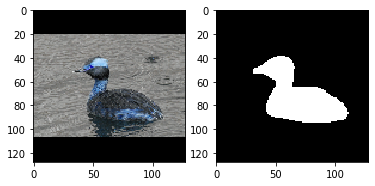

In [8]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(img_batch[0])
axes[1].imshow(np.squeeze(mask_batch[0]), cmap='gray')

## Create network

First, the `tf.keras.Model` and `tf.optimizers` are put together as `FEModel`.

In [9]:
model = fe.build(model_def=UNet, model_name="unet_cub", optimizer=tf.optimizers.Adam(lr=0.001), loss_name="loss")

Then we combine the `FEModel` and `Loss` together as `Network`.

In [10]:
network = fe.Network(ops=[
    ModelOp(inputs='image', model=model, outputs='mask_pred'),
    BinaryCrossentropy(y_true='annotation', y_pred='mask_pred', outputs="loss")
])

## Create Estimator

`Trace` is similar to callbacks in `tf.keras`. You can specify the metrics you would like to use. In this example we use Dice score. To save your model, you can use the `ModelSaver`. We will save our model in the `save_dir` folder.

In [15]:
save_dir = tempfile.mkdtemp()

In [11]:
traces = [
    Dice(true_key="annotation", pred_key='mask_pred'),
    ModelSaver(model_name="unet_cub", save_dir=save_dir, save_best='dice', save_best_mode='max')
]

After combining everything into `Estimator` we can start training!

In [12]:
estimator = fe.Estimator(network=network, pipeline=pipeline, traces=traces, epochs=epochs, steps_per_epoch=steps_per_epoch)

## Start traininig

In [13]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator: Reading non-empty directory: /tmp/.fe/CUB200/FEdata
FastEstimator: Found 4827 examples for train in /tmp/.fe/CUB200/FEdata/train_summary0.json
FastEstimator: Found 1206 examples for eval in /tmp/.fe/CUB200/FEdata/eval_summary0.json
FastEstimator-Start: step: 0; unet_cub_lr: 0.001; 


W0918 16:07:27.013855 140255972329216 deprecation.py:323] From /data/hsiming/virtualenv/tf2.0.0b_py36_hsiming/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


FastEstimator-Train: step: 0; loss: 0.7021471; 
FastEstimator-ModelSaver: Saving model to /tmp/tmpduzk8yc3/unet_cub_best_dice.h5
FastEstimator-Eval: step: 75; epoch: 0; loss: 0.24989241; min_loss: 0.24989241; since_best_loss: 0; dice: 7.588908961103451e-11; 
FastEstimator-Train: step: 100; loss: 0.2297919; examples/sec: 33.8; 
FastEstimator-ModelSaver: Saving model to /tmp/tmpduzk8yc3/unet_cub_best_dice.h5
FastEstimator-Eval: step: 150; epoch: 1; loss: 0.22817911; min_loss: 0.22817911; since_best_loss: 0; dice: 7.592279165819584e-11; 
FastEstimator-Train: step: 200; loss: 0.2402322; examples/sec: 33.45; 
FastEstimator-ModelSaver: Saving model to /tmp/tmpduzk8yc3/unet_cub_best_dice.h5
FastEstimator-Eval: step: 225; epoch: 2; loss: 0.23342162; min_loss: 0.22817911; since_best_loss: 1; dice: 0.6237118417721643; 
FastEstimator-ModelSaver: Saving model to /tmp/tmpduzk8yc3/unet_cub_best_dice.h5
FastEstimator-Eval: step: 300; epoch: 3; loss: 0.19668888; min_loss: 0.19668888; since_best_loss: 

## Inference

In [18]:
model = load_model(os.path.join(save_dir, 'unet_cub_best_dice.h5'))

W0918 16:41:14.391707 140255972329216 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [20]:
predicted_mask = model.predict(img_batch)

Text(0.5, -0.3, 'segmentation mask')

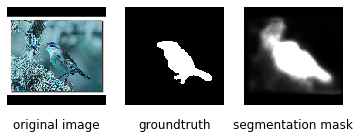

In [41]:
batch_index = 1
fig, axes = plt.subplots(1, 3)
axes[0].imshow(img_batch[batch_index])
axes[0].axis('off')
axes[0].set_title('original image', y=-0.3)
axes[1].imshow(np.squeeze(mask_batch[batch_index]), cmap='gray')
axes[1].axis('off')
axes[1].set_title('groundtruth', y=-0.3)
axes[2].imshow(np.squeeze(predicted_mask[batch_index]), cmap='gray')
axes[2].axis('off')
axes[2].set_title('segmentation mask', y=-0.3)